In [64]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from PIL import Image

In [2]:
from pathlib import Path

## Dataset

The dataset is a set of audio recordings from cats. Samples are short clips (1-2 seconds) grouped in three classes:
- brushing the cat
- cat is in unfamiliar environment (discomfort)
- waiting for food

Source: https://zenodo.org/record/4008297

In [3]:
dataset_dir = Path('/home/flo/projects/data-playground/data/catmeows/wav')
dataset_png = dataset_dir.parent / 'png'

## Convert audio samples into images of spectograms

In [4]:
from scipy.io import wavfile
from scipy import signal
import numpy as np

# source: https://stackoverflow.com/questions/47954034/plotting-spectrogram-in-audio-analysis/47954408
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
def wav_to_png(path_wav, write=False):
    path_png = dataset_png / f'{path_wav.stem}.png'
    
    # read wave file
    sample_rate, audio = wavfile.read(path_wav)

    # turn audio into spectogram
    freqs, times, specgram = log_specgram(audio, sample_rate)
    
    # bring into range 0..255
    specgram_normed = (specgram + abs(specgram.min())) / (abs(specgram.min()) + specgram.max())
    specgram_normed = (specgram_normed * 255).astype(np.uint8) 
    
    # save as image
    if write:
        data = Image.fromarray(specgram_normed)
        data.save(path_png)
    return path_png

In [6]:
paths_wav = list(dataset_dir.glob('*.wav'))
paths_png = [
    wav_to_png(path_wav)
    for path_wav
    in paths_wav
]

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Look at some example spectrograms

In [7]:
import IPython

def show_sample(idx):
    IPython.display.display(IPython.display.Audio(paths_wav[idx]))
    IPython.display.display(IPython.display.Image(paths_png[idx]))

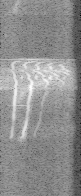

In [73]:
show_sample(24)

## Inspect (some) shapes

In [9]:
for idx in range(5):
    print(np.array(Image.open(paths_png[idx])).shape)

(140, 81)
(125, 81)
(150, 81)
(155, 81)
(161, 81)


## DataLoader

In [13]:
import fastbook
fastbook.setup_book()
from fastbook import *

In [14]:
from torchvision import transforms
transforms.Pad

torchvision.transforms.transforms.Pad

In [47]:
label_dict = {
    'B': 'brushing',
    'F': 'hungry',
    'I': 'discomfort'
}
def label_func(fname):
    # B = brushing; F = waiting for food; I: isolation in an unfamiliar environment);
    return label_dict[fname.name[0]]

def get_dataloaders(batch_size=32):
    data = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(),  # TODO: clean split so that same cats doesn't appear in both sets
        item_tfms=[CropPad(81)],
        #         item_tfms=[Resize(81, method=ResizeMethod.Crop)],  # transforms.Pad(8), transforms.CenterCrop(81)
        get_y=label_func, 
    )
    
    return data, data.dataloaders(dataset_png, bs=batch_size)
datablock, dls = get_dataloaders()

In [48]:
datablock.summary(dataset_png)

Setting-up type transforms pipelines
Found 440 items
2 datasets of sizes 352,88
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/flo/projects/data-playground/data/catmeows/png/I_NUL01_MC_MI_SIM01_205.png
    applying PILBase.create gives
      PILImageBW mode=L size=81x213
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/flo/projects/data-playground/data/catmeows/png/I_NUL01_MC_MI_SIM01_205.png
    applying label_func gives
      discomfort
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=81x213, TensorCategory(1))


Found 440 items
2 datasets of sizes 352,88
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': Tr

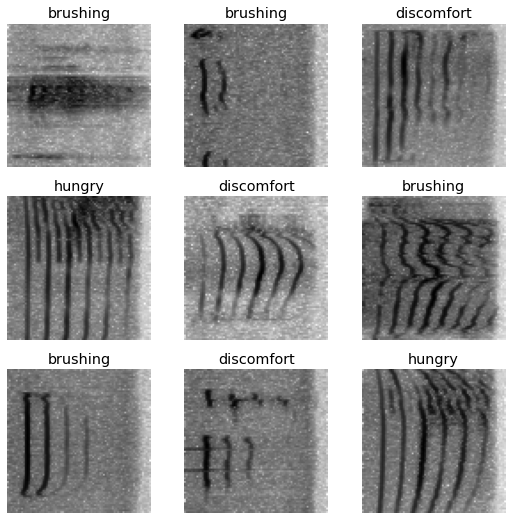

In [45]:
dls.show_batch()

## ConvNet model

In [32]:
class cast_to_tensor(Module):
    "Workoaround: https://github.com/fastai/fastai/issues/2769#issuecomment-824186215"
    def forward(self, x):
        return cast(x, Tensor)

In [75]:
in_shape = (81, 81)  # time, frequencies, channels
n_classes = 3
def simple_net(): 
    return nn.Sequential(
        nn.Conv2d(1, 4, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(4, 8, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(16, n_classes, 3),
        nn.Flatten(),
#         nn.Linear(16, n_classes),
        cast_to_tensor()
    )

In [76]:
learn = Learner(
        dls,
        simple_net(),
        loss_func=F.cross_entropy,
        metrics=accuracy
    )

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.17378008365631104)

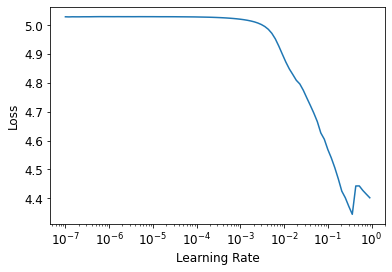

In [77]:
learn.lr_find()

In [52]:
def fit(epochs=10):
    learn = Learner(
        dls,
        simple_net(),
        loss_func=F.cross_entropy,
        metrics=accuracy,
        cbs=[ActivationStats(with_hist=True)]
    )
    learn.fit(epochs, 0.005)
    return learn


learn = fit()

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,4.513957,3.920902,0.034091,00:00
1,4.177407,3.880727,0.034091,00:00
2,4.046599,3.776906,0.113636,00:00
3,3.935840,3.529075,0.170455,00:00
4,3.796598,3.200057,0.181818,00:00
5,3.653109,3.042237,0.136364,00:00
6,3.536584,2.971494,0.147727,00:00
7,3.432124,2.882946,0.125000,00:00
8,3.340566,2.830138,0.136364,00:00
9,3.262114,2.808401,0.147727,00:00


## Classification results

In [63]:
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

AssertionError: ==:
12936
88

### Activations on first layer

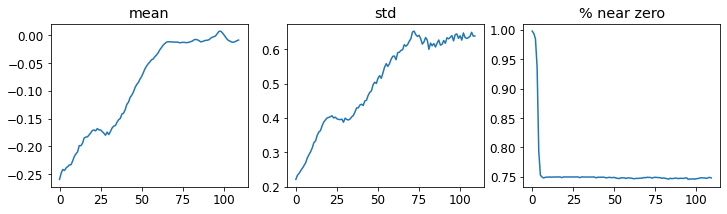

In [53]:
learn.activation_stats.plot_layer_stats(0)

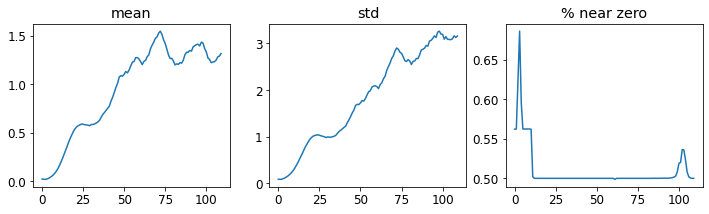

In [55]:
learn.activation_stats.plot_layer_stats(-2)

### Try 1cycle

In [57]:
learn = Learner(
    dls,
    simple_net(),
    loss_func=F.cross_entropy,
    metrics=accuracy,
    cbs=[ActivationStats(with_hist=True)]
)
learn.fit_one_cycle(10, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,4.954216,4.882213,0.034091,00:00
1,4.678709,3.915066,0.011364,00:00
2,4.360333,3.731165,0.090909,00:00
3,4.111183,3.294499,0.193182,00:00
4,3.859250,3.050936,0.147727,00:00
5,3.678968,3.005703,0.147727,00:00
6,3.545033,2.962092,0.159091,00:00
7,3.445348,2.947575,0.159091,00:00
8,3.370137,2.941942,0.170455,00:00
9,3.313263,2.941331,0.170455,00:00


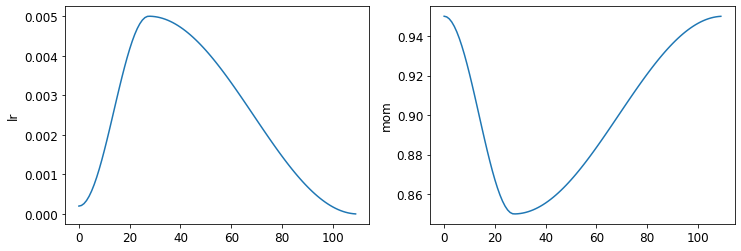

In [58]:
learn.recorder.plot_sched()

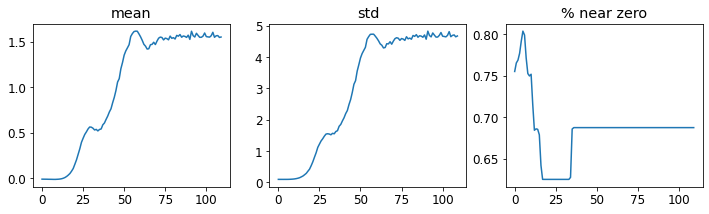

In [59]:
learn.activation_stats.plot_layer_stats(-2)

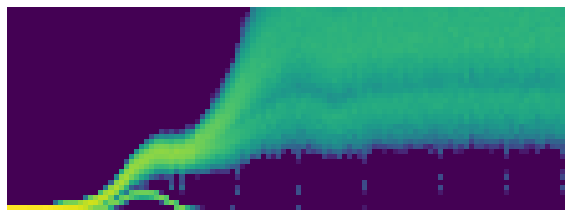

In [60]:
learn.activation_stats.color_dim(-2)